## Load the processed version of the data file

In [1]:
import time
import sys
import numpy as np
import pandas as pd

In [2]:
#takes about 40 secs to load
path = 'data/processed/LoanStats-combined-z-2.csv'
t1 = time.time()
df = pd.read_csv(path)
t2 = time.time()
print "{} bytes loaded in {:0.3f} secs".format(sys.getsizeof(df),t2-t1)
print df.shape


/Users/stephane/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,47,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2095270415 bytes loaded in 26.297 secs
(887382, 150)


## Finally, create a list of features for fitting a model

As a first pass, I'm only pulling out numeric features. Text processing can be added later.

In [71]:
# I spent an unnecessary amount of time figuring out how to do this, and it turns out there's  a builtin for it...
working_feature_cols=list(df._get_numeric_data().columns) 
print "non-numeric cols:"
print set(df.columns) - set(working_feature_cols)
# remove cols we won't use for model fitting
skip_cols = [
    'lc_id', 'member_id', 'loan_status_num', 'grade_num',
    'collection_recovery_fee',
    'out_prncp',
    'out_prncp_inv',
    'pymnt_plan',
    'recoveries',
    'sub_grade',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp'
    ]
zil_cols = ['zil_coef', 'zil_interc']
print "numeric feature cols ({}):".format(len(working_feature_cols))
print working_feature_cols

non-numeric cols:
set(['grade', 'application_type', 'emp_length', 'last_credit_pull_d', 'emp_title', 'verification_status_joint', 'title', 'initial_list_status', 'next_pymnt_d', 'earliest_cr_line', 'zip_code', 'verification_status', 'last_pymnt_d', 'sub_grade', 'pymnt_plan', 'purpose', 'addr_state', 'desc', 'term', 'url', 'revol_util', 'int_rate', 'loan_status', 'home_ownership', 'issue_d'])
numeric feature cols (125):
['lc_id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal

## After all that, finally ready to try to fit something?

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics


### Initially, downsample the DataFrame for quicker testing

This also filters out rows with no zillow zip code, and rows who's loan status is different from what we want

In [44]:
validindexlist=((df.loan_status_num == 1) | (df.loan_status_num == 0)) & (~np.isnan(df.zil_coef))
# use random_state = 33 for unbridled success!
minidf=df[validindexlist].sample(n=20000,random_state=33).fillna(0)
#validindexlist2=((df.loan_status_num == 1) | (df.loan_status_num == 0)) & (~np.isnan(df.zil_coef))
#minidf2=df[validindexlist2].sample(n=10000,random_state=33).fillna(0)
minidf.sort_values(by='grade_num',inplace=True)
print len(validindexlist)
print validindexlist.value_counts()
print minidf.shape

887382
True     604545
False    282837
dtype: int64
(20000, 150)


### Okay setup X and y for analysis:

In [49]:
#X = df[num_cols][validindexlist].fillna(0)
#X = pd.DataFrame(minidf['grade_num'][validindexlist].fillna(0)) # just grade num, like before
#X = pd.DataFrame(
#    df[(list(['grade_num'])+num_cols)[0:10]][validindexlist].fillna(0)) # new vals + grade_num
# X = pd.DataFrame(minidf[num_cols[0:10]][validindexlist].fillna(0)) # just a few new features
X = minidf[list(set(working_feature_cols)-set(skip_cols)-set(zil_cols))]
Xz = minidf[list(set(working_feature_cols)-set(skip_cols))]
y = minidf.loan_status_num
print type(X) ,X.shape
print type(Xz) ,Xz.shape
print type(y), y.shape
print np.isnan(y).value_counts()
print 'done'

<class 'pandas.core.frame.DataFrame'> (20000, 110)
<class 'pandas.core.frame.DataFrame'> (20000, 112)
<class 'pandas.core.series.Series'> (20000,)
False    20000
Name: loan_status_num, dtype: int64
done


## Correlation of features. This didn't really go anywhere.


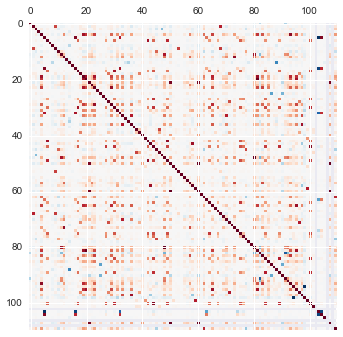

In [51]:
plt.figure(figsize=(16, 16))
corr = X.corr()
plt.matshow(corr,cmap=plt.cm.RdBu_r)
#plt.xticks(range(len(corr.columns)), corr.columns);
#plt.yticks(range(len(corr.columns)), corr.columns);

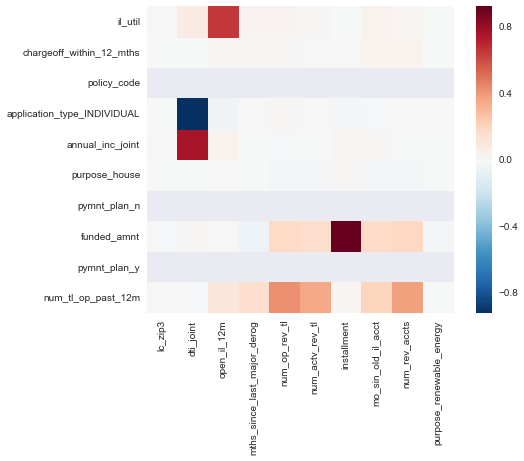

In [52]:
import seaborn as sns
sns.heatmap(corr[corr.columns[15:25]].iloc[100:], vmax=.8, square=True)

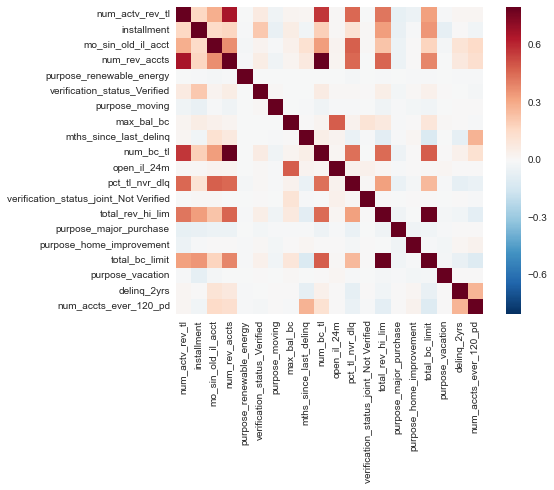

In [53]:
import seaborn as sns
sns.heatmap(corr[corr.columns[20:40]].iloc[20:40], vmax=.8, square=True)

In [54]:
corr[corr.columns[15:25]].tail(10)

,lc_zip3,dti_joint,open_il_12m,mths_since_last_major_derog,num_op_rev_tl,num_actv_rev_tl,installment,mo_sin_old_il_acct,num_rev_accts,purpose_renewable_energy
il_util,0.003439,0.076407,0.654451,0.023278,0.024633,0.014349,-0.004661,0.037502,0.015061,-0.004103
chargeoff_within_12_mths,-0.003138,-0.002141,0.008717,0.010376,0.011030,0.005333,0.004104,0.033827,0.041682,-0.002474
policy_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_type_INDIVIDUAL,-0.003930,-0.925000,-0.037028,0.002714,0.009067,0.002442,-0.015074,-0.013791,0.003408,0.000749
annual_inc_joint,0.005594,0.758852,0.035736,-0.003779,-0.008780,-0.002578,0.018325,0.011985,-0.002507,-0.000692
purpose_house,-0.000520,-0.001482,0.002789,-0.003259,-0.020392,-0.018688,0.007707,-0.017232,-0.018189,-0.001713
pymnt_plan_n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
funded_amnt,-0.014146,0.013590,0.003444,-0.050618,0.185372,0.171660,0.947203,0.180002,0.189205,-0.015949
pymnt_plan_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_tl_op_past_12m,0.006159,-0.011402,0.109688,0.158500,0.421197,0.357684,0.017085,0.205758,0.380293,-0.001150


## To begin, use GridSearchCV to  Fit a bunch of logregs & find best estimator



In [64]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from operator import itemgetter

#scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
# from 
# http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html
# example-model-selection-randomized-search-py
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [72]:
# random_state = 2 was pretty good
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
Xz_train, Xz_test, yz_train, yz_test = train_test_split(Xz, y, random_state=2)
print all(y_train == yz_train)
print all(yz_test == y_test)

True
True


In [73]:
logreg = LogisticRegression()
logregz = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

# run grid search
grid_search = GridSearchCV(logreg, param_grid=param_grid)
grid_searchz = GridSearchCV(logreg, param_grid=param_grid)
start = time.time()
grid_search.fit(X_train, y_train)
grid_searchz.fit(Xz_train, yz_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(grid_search.grid_scores_)))
print "Without Zillow:"
report(grid_search.grid_scores_,n_top=1)
print "With Zillow:"
report(grid_searchz.grid_scores_,n_top=1)
logreg = grid_search.best_estimator_
logregz = grid_searchz.best_estimator_


GridSearchCV took 71.25 seconds for 7 candidate parameter settings.
Without Zillow:
Model with rank: 1
Mean validation score: 0.936 (std: 0.000)
Parameters: {'C': 0.1}

With Zillow:
Model with rank: 1
Mean validation score: 0.937 (std: 0.000)
Parameters: {'C': 1}



## Okay, how did the model do?

In [58]:
from sklearn.cross_validation import cross_val_predict
#y_pred_class = cross_val_predict(logreg, X, y, cv=10)
y_pred_class = grid_search.predict(X_test)
y_pred_prob = grid_search.predict_proba(X_test)[:,1]

In [59]:
#y_test = y
print "percent of loans successful in y_test: {}/{} = {}".format(
    y_test[y_test == 1].count(), y_test.count(),
    float(y_test[y_test == 1].count())/ y_test.count() )
print metrics.accuracy_score(y_test,y_pred_class)

percent of loans successful in y_test: 4688/5000 = 0.9376
0.9372


In [60]:
print "percent of loans successful in y_test: {}/{} = {}".format(
    y_test[y_test == 1].count(), y_test.count(),
    float(y_test[y_test == 1].count())/ y_test.count() )
print "percent of loans predicted to be successful: {}/{} = {}".format(
    y_pred_class.sum() , len(y_pred_class),
    float(y_pred_class.sum())/len(y_pred_class))
                                                                 
a = [i for i,x in enumerate(y_pred_class) if x != 1] # false predictions
print len(a), a
print y.iloc[a]
#print logreg2.classes_
#print y_pred_prob[a]
#print y_pred_prob[0:3]

print 'done'

percent of loans successful in y_test: 4688/5000 = 0.9376
percent of loans predicted to be successful: 4998.0/5000 = 0.9996
2 [2342, 4735]
33411    1.0
38984    1.0
Name: loan_status_num, dtype: float64
done


### (this will be a good spot for a confusion matrix)

In [61]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print confusion
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
print 'True Positives:', TP
print 'True Negatives:', TN
print 'False Positives:', FP
print 'False Negatives:', FN
# calculate the sensitivity
print TP / float(TP + FN)
# calculate the specificity
print TN / float(TN + FP)

[[   0  312]
 [   2 4686]]
True Positives: 4686
True Negatives: 0
False Positives: 312
False Negatives: 2
0.99957337884
0.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1377b2610>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1367371d0>], dtype=object)

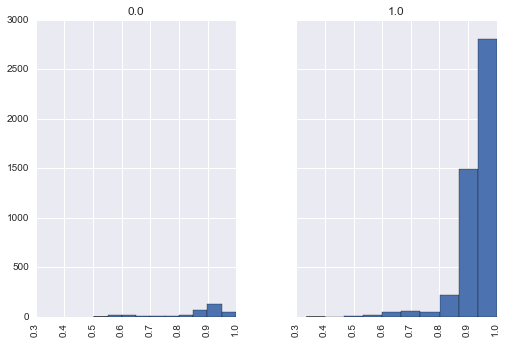

In [62]:
tempdf = pd.DataFrame({'probability':y_pred_prob, 'actual':y_test})
tempdf.hist(column='probability', by='actual', sharex=True, sharey=True)

0.732655525291
0.919051466522


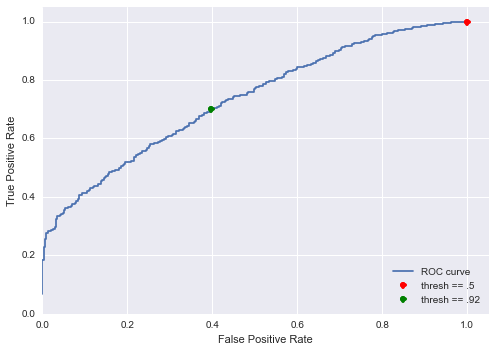

In [63]:
# ROC curve 
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr,label = "ROC curve")
thresh_i = np.where(thresholds>.5)[0][-1]
plt.plot(fpr[thresh_i],tpr[thresh_i],'ro',label = 'thresh == .5')
thresh2 = np.where(tpr>.7)[0][0]
plt.plot(fpr[thresh2],tpr[thresh2],'go',label = 'thresh == .92')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print metrics.roc_auc_score(y_test, y_pred_prob)
print thresholds[tpr>.7][0]

<type 'numpy.ndarray'>
[ 0.9999999   0.99999985  0.99999981  0.9999998   0.99999978  0.99999976
  0.99999974  0.99999972  0.99999957  0.99999955]
0.999147848317
0.999147848317


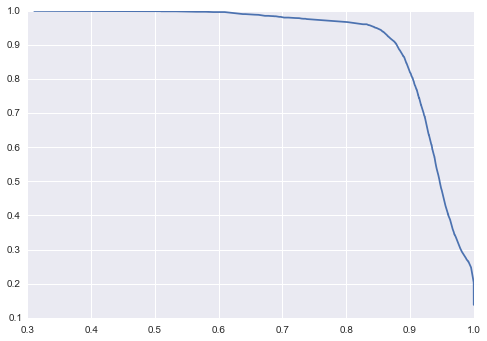

In [27]:
print type(tpr)
plt.plot(thresholds,tpr)
print thresholds[0:10]
print tpr[np.where(thresholds>.5)[0][-1]]
print tpr[thresholds>.5][-1]

### To check results of the fit, plot the predicted probabilities

This was a first attempt to view a correlation between the predicted probabilities and the outcomes of the loans. I hoped to see more 'defaults' (black points) toward the left, at the lower probabilities. However this graph didn't work very well.

/Users/stephane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


<class 'pandas.core.series.Series'>
2500 2500
1.0 0.0
(2500,) (2500,) 2500 (2500,)


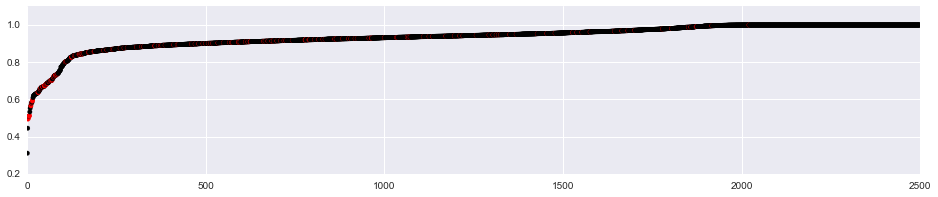

In [28]:
sis = y_pred_prob.argsort()
colormap = np.array(['r', 'k'])
plt.figure(figsize=(16, 3))
plt.scatter(range(len(y_pred_prob)),y_pred_prob[sis],color=colormap[list(y_test.iloc[sis])])
plt.xlim([0,len(y_test)])
#plt.scatter(range(len(y_test)),y_test.iloc[sis],color=colormap[list(y_test.iloc[sis])])
print type(y_test)

print len(y_test),len(sis)
print max(y_test),min(y_test)
print y_test.shape,sis.shape,len(y_test[sis]),y_test[sis].shape

### Second attempt to evaluate the model graphically

This graph shows a boxplot of predicted probabilities broken down into 2 groups based on outcome. It is clear that 'successful' loans (loan_status_num ==1) have a higher distribution of predicted probabilites than 'unsuccessful' loans (loan_status_num == 0).

1.0    2347
0.0     153
Name: loan_status_num, dtype: int64


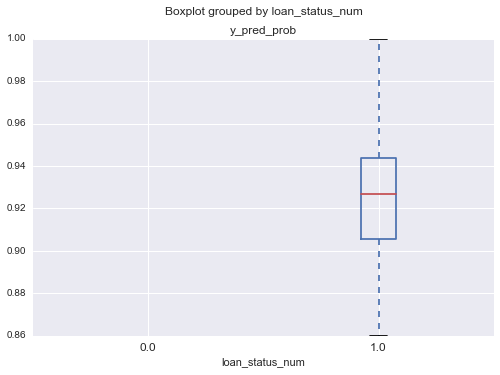

In [29]:
# merge these things into a single dataframe for plotting:
testdf=pd.concat([X_test,y_test,pd.DataFrame(y_pred_prob,columns=['y_pred_prob'])],axis=1)
testdf.boxplot(column='y_pred_prob',by='loan_status_num')
print testdf.loan_status_num.value_counts()

In [30]:
grouped = testdf.groupby('loan_status_num')
grouped.y_pred_prob.quantile([.25, .5, .75, 1])


loan_status_num
0.0                                                  NaN
1.0    0.25    0.905609
0.50    0.926828
0.75    0.94...
Name: y_pred_prob, dtype: object

In [31]:
#plt.scatter(df.grade_num,df.loan_status_num,label='loan status')
#plt.plot(df2.grade_num,df2.loan_status_pred_num,color='red')
#plt.plot(X_test['grade_num'].sort_values(),y_pred_class,color='red')
#plt.setp(plt.gca(), xticklabels=gradenames, xticks = gradenums)
#plt.setp(plt.gca(), yticklabels=np.arange(0,1.2,.2), yticks = np.arange(0,1.2,.2))
#plt.setp(plt.gca(),title = 'Predicted loan status, test set')

## next...

In [32]:
print 'done'

done


In [33]:
#print total_success_rate
print "percent of loans successful in y_test: {}/{} = {}".format(y_test[y_test == 1].count(), y_test.count(),
                                                       float(y_test[y_test == 1].count())/ y_test.count() )
print "logreg class prediction accuracy:" , metrics.accuracy_score(y_test, y_pred_class)
print "guess all successful accuracy: ", metrics.accuracy_score(y_test,[1]*len(y_test))

percent of loans successful in y_test: 2347/2500 = 0.9388
logreg class prediction accuracy: 0.9384
guess all successful accuracy:  0.9388


In [34]:
grouped=minidf.groupby('grade')
probs=grouped.loan_status_num.sum()/grouped.loan_status_num.count()
print probs

grade
A    0.978451
B    0.953488
C    0.941840
D    0.894385
E    0.898148
F    0.845283
G    0.729167
Name: loan_status_num, dtype: float64


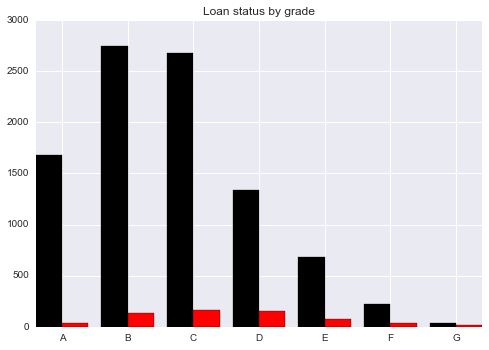

In [35]:
fig,ax = plt.subplots()
width=.4
xlocs=np.arange(0,7)
ax.bar(xlocs-width,grouped.loan_status_num.sum(),width,color='k')
ax.set_xticks(xlocs)
ax.set_xticklabels(sorted(minidf.grade.unique()))
ax.bar(
        xlocs,grouped.loan_status_num.apply(lambda item: (item == 0).sum()),width,
        color='r')
ax.set_title('Loan status by grade')

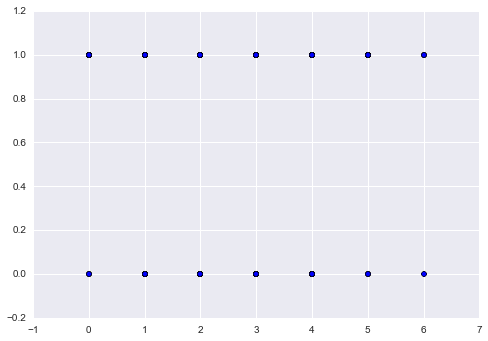

In [36]:
#df2['loan_status_pred_prob']=logreg.predict_proba(X)[:,1]
plt.scatter(minidf.grade_num,minidf.loan_status_num)

In [37]:
#plt.plot(minidf.grade_num,minidf.loan_status_pred_prob,color='red')
X_test_s=minidf.sort_values(by='grade_num').grade_num.reshape(-1,1)
plt.plot(X_test_s,logreg.predict_proba(X_test_s)[:,1],color='red')

plt.plot(probs,'go-')

ValueError: X has 1 features per sample; expecting 112